## Introduction

This dataset is from kaggle and as such all rights belong to the authors. While the original goal of this project is to determine future house price projections, the true purpose is to practice and get familiar with a wide variety of data science tools and techniques. Like in the real world, first go through mountains of raw data, select the most relevant variables based on logical analysis, filter data, come up with several models using different techniques, test them using test-datasets, and finally choose the most promising model.

The learning objective of this project:
- linear regression
- machine learning
- Handle missing values
- training and testing models
- Applying algorithms to boost accuracy

Below are the table of contents:
1. Overview of dataset
2. Fill in missing data
3. Determine relevant variables
4. Filter data
5. Create models
6. Test models
7. Conclusion plot

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Overview of dataset

First lets take look at the data set we have. Open the training data set in the csv file. 

In [85]:
df = pd.read_csv("resources/train.csv")
display(df)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


We can also save it as an excel file for readability in offline. For this you need to install the module 'openpyxl' with pip

In [86]:
# df.to_excel("resources/train.xlsx", index=False)

As shown above there are in total 79 explanatory variables but not all of them are relevant and some have quite a lot of missing data. Let's get a general idea of what the biggest explanatory variables can be by creating a correlation heat map

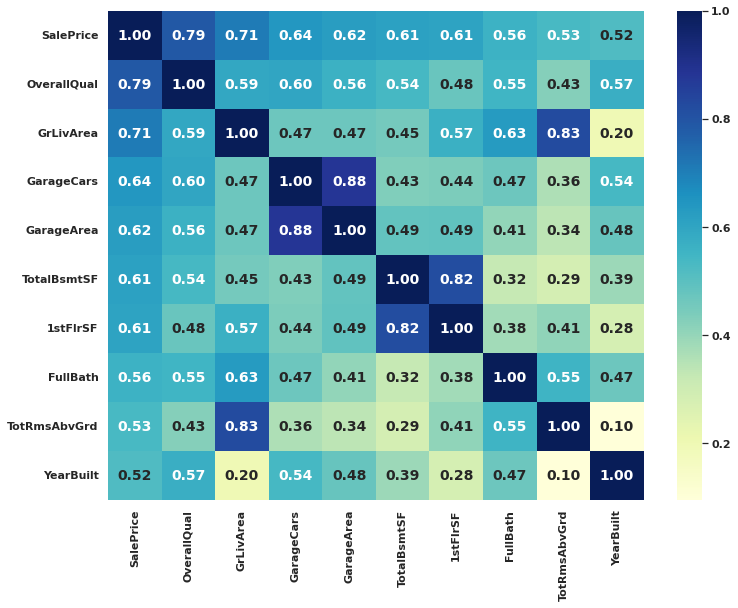

In [87]:
#correlation matrix
corrmat = df.corr()
fig, ax = plt.subplots(figsize=(12, 9))
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Based on the correlation heat map, we see that variables related to areas are the most contributors to sale price. Variables like 'GarageCars' or 'FullBath' indirectly indicates area. Therefore, it is safe to assume that we should pay attention to variables that indicate area.

## 2. Fill in missing data

Some of the variables have missing data. Let's first determine the variables with the most missing data by calculate the percentage. 

In [88]:
total = df.isnull().sum()
percent = (100 * total/len(df.index)).sort_values(ascending=False)
display(percent.head(20))

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Id               0.000000
dtype: float64

We can either drop the columns or perform imputation, which is replacing missing data with a certain value. We drop a variable when:
- More than 15% of the data is missing
- It is likely to be an outlier
- It is a sub-variables of another main variable

The columns 'PoolQC' all the way to 'LotFrontage' have more than 15% data missing thus they can be dropped.

In [89]:
df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], 
        inplace=True)

Looking closely at the variables, we see that GarageArea tends to be the dominant variable amongst other garage related variables. Therefore we can drop all the garage related variables except for GarageArea. We can apply the same logic to basement related variables.

In [90]:
df.drop(columns=['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageCars', 'BsmtFinType2', 
                 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], inplace=True)

Later on, we won't be needing the bottom three variables as well but for the sake of learning, we will perform imputation. 'MasVnrArea' has integer data type while 'Electrical' and 'MasVnrType' have strings. Therefore the imputation for 'MasVnrArea' will be the mean while the other two will be most frequent string value

In [91]:
# my_imputer = SimpleImputer()
# data_with_imputed_values = my_imputer.fit_transform(df.Electrical)
si=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
transformed = si.fit_transform([df.Electrical])

## 3. Determine relevant variables

Now that we have dropped some irrelevant variables let us create the correlation heatmap again.

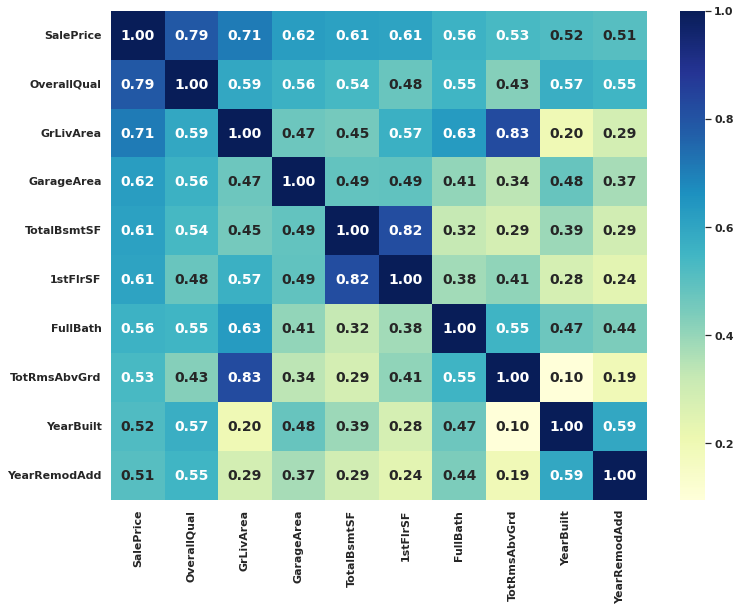

In [92]:
#correlation matrix
corrmat = df.corr()
fig, ax = plt.subplots(figsize=(12, 9))
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Based on the above graph the following variables are candidates for our model:
- OverallQual: Rates the overall material and finish of the house
- GrLivingArea: Above ground living area in square feat
- GarageArea: Size of garage in square feet
- TotalBsmtSF: Total square feet of basement area
- 1stFlrSF: First Floor square feet
- FullBath: Full bathrooms above grade
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date. If never remodeled same as built date

But 9 explanatory variables still seem too many. Let's see each of their scatter plot in correlation to the sale price:

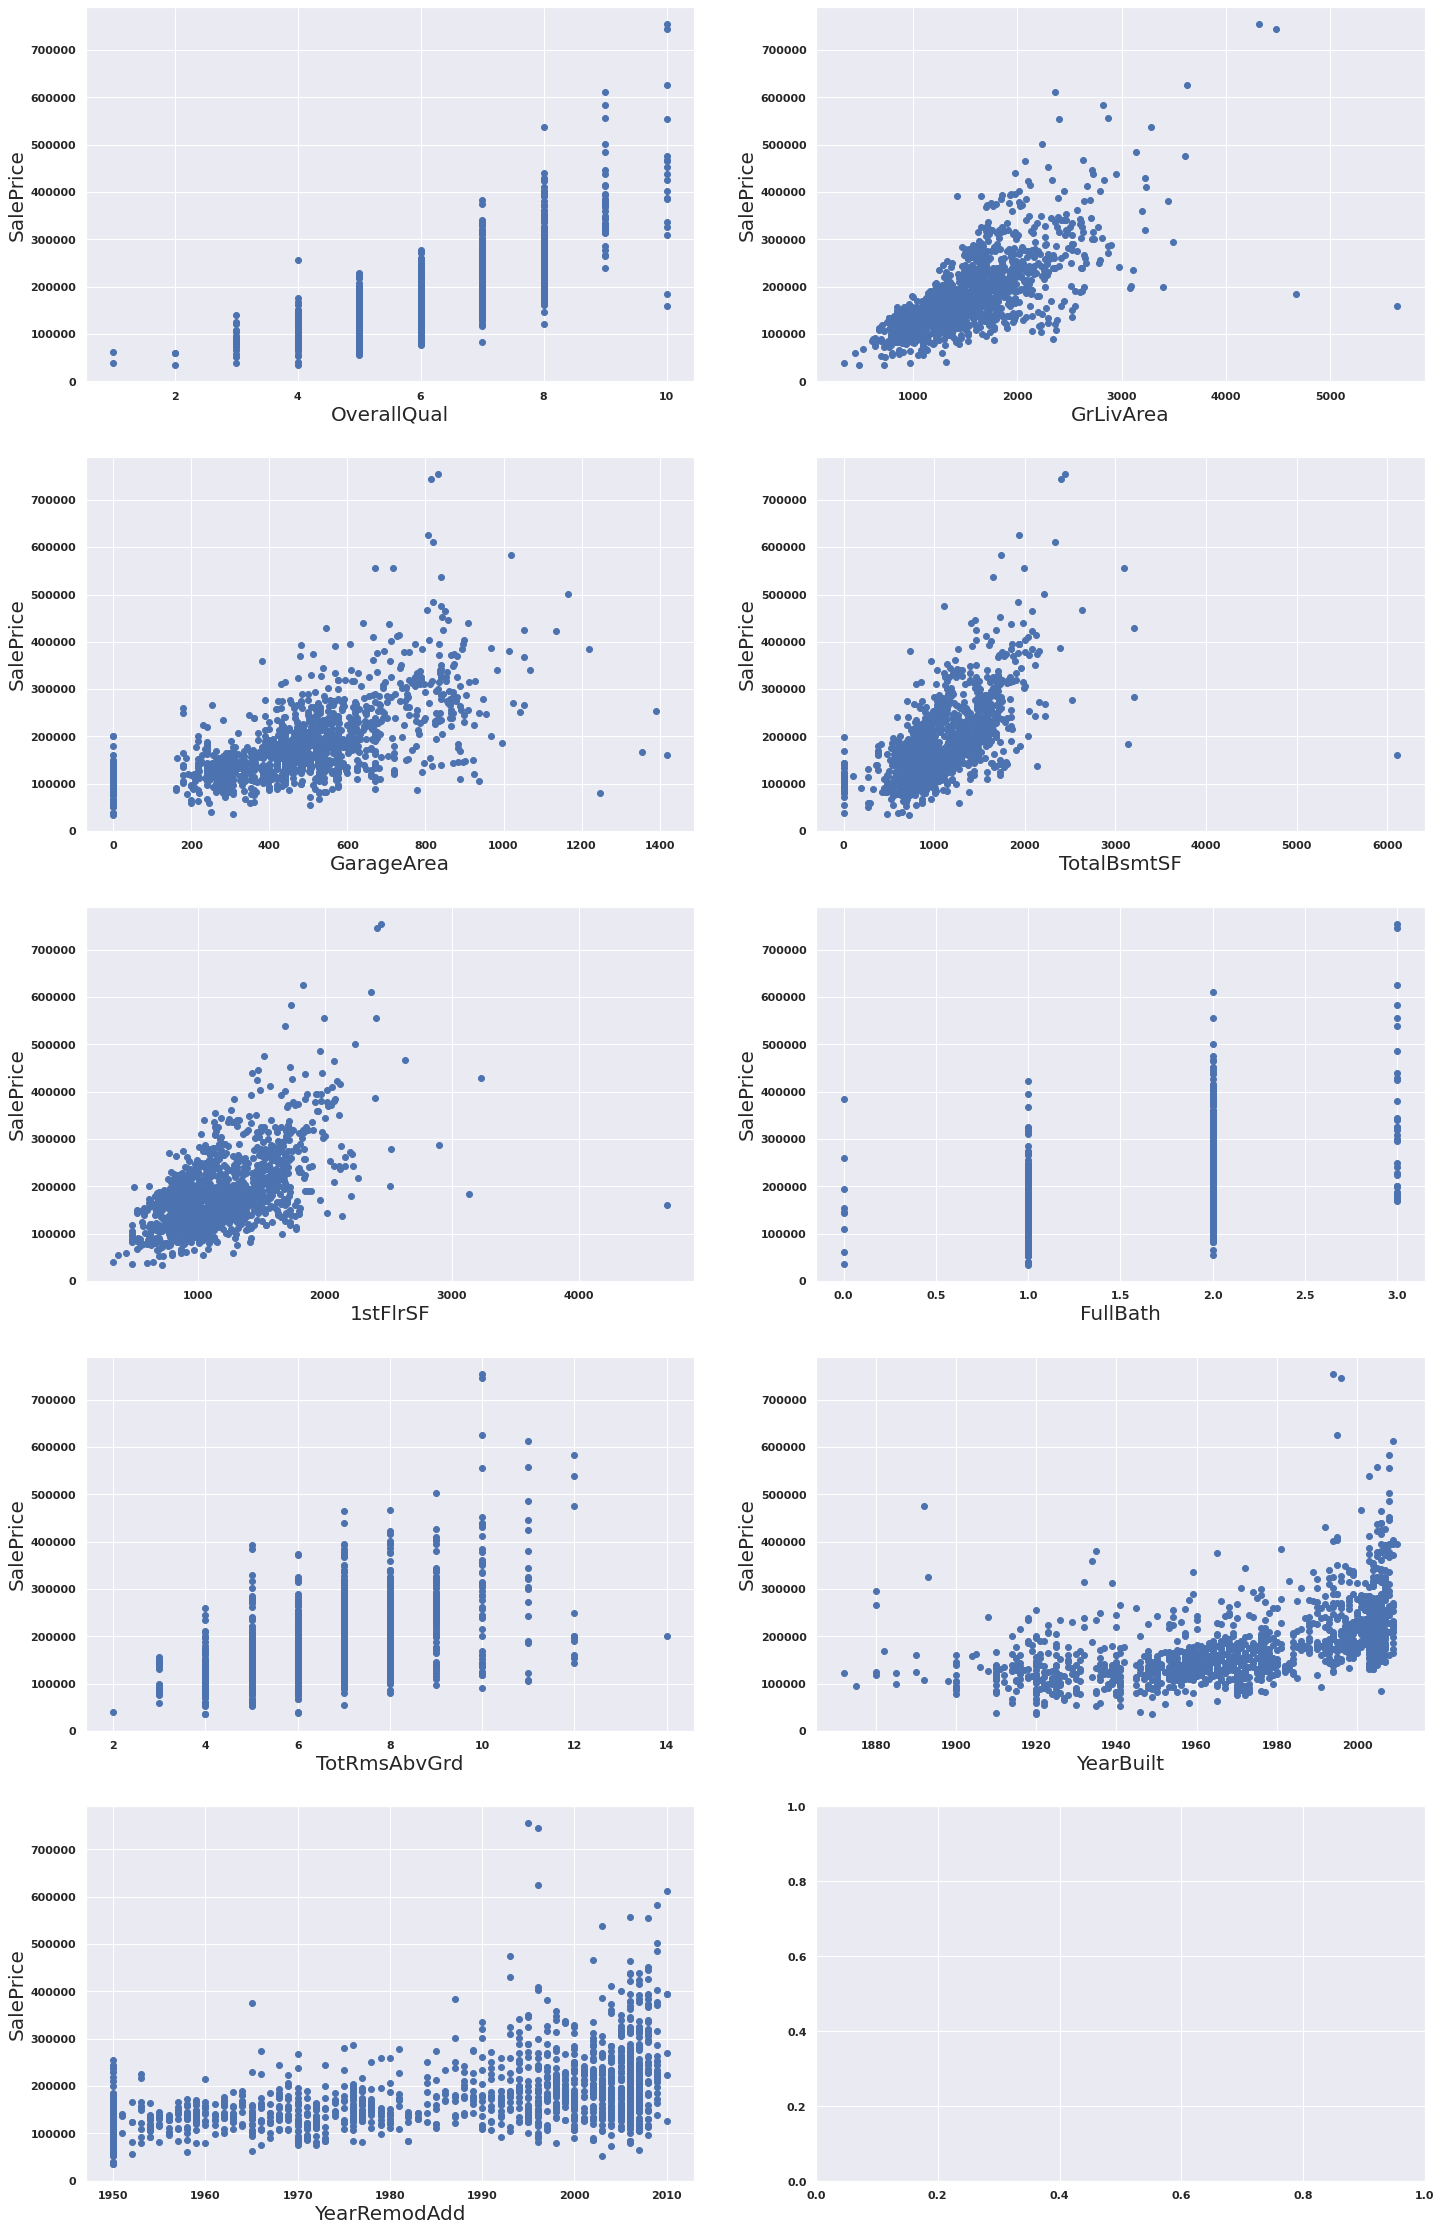

In [93]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2, figsize =(24,40))

ax1.set_xlabel('OverallQual', fontsize=20)
ax1.set_ylabel('SalePrice', fontsize=20)
ax2.set_xlabel('GrLivArea', fontsize=20)
ax2.set_ylabel('SalePrice', fontsize=20)
ax3.set_xlabel('GarageArea', fontsize=20)
ax3.set_ylabel('SalePrice', fontsize=20)
ax4.set_xlabel('TotalBsmtSF', fontsize=20)
ax4.set_ylabel('SalePrice', fontsize=20)
ax5.set_xlabel('1stFlrSF', fontsize=20)
ax5.set_ylabel('SalePrice', fontsize=20)
ax6.set_xlabel('FullBath', fontsize=20)
ax6.set_ylabel('SalePrice', fontsize=20)
ax7.set_xlabel('TotRmsAbvGrd', fontsize=20)
ax7.set_ylabel('SalePrice', fontsize=20)
ax8.set_xlabel('YearBuilt', fontsize=20)
ax8.set_ylabel('SalePrice', fontsize=20)
ax9.set_xlabel('YearRemodAdd', fontsize=20)
ax9.set_ylabel('SalePrice', fontsize=20)


Y = df['SalePrice']
X1 = df['OverallQual']
X2 = df['GrLivArea']
X3 = df['GarageArea']
X4 = df['TotalBsmtSF']
X5 = df['1stFlrSF']
X6 = df['FullBath']
X7 = df['TotRmsAbvGrd']
X8 = df['YearBuilt']
X9 = df['YearRemodAdd']


ax1.scatter(X1, Y)
ax2.scatter(X2, Y)
ax3.scatter(X3, Y)
ax4.scatter(X4, Y)
ax5.scatter(X5, Y)
ax6.scatter(X6, Y)
ax7.scatter(X7, Y)
ax8.scatter(X8, Y)
ax9.scatter(X9, Y)

Based on the above we can drop a few more variables with lower correlation: YearRemodAdd, YearBuilt, TotRmsAbvGrd, FullBath. Since we know every other variable below YearRemodAdd has lower correlation, we can focus on the following variables:
- SalePrice
- OverallQual
- GrLivArea
- GarageArea
- TotalBsmtSF
- 1stFlrSF

As stated before, most of the variables are related to area.  

In [94]:
df.drop(df.columns.difference(['SalePrice','OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF'])
        , 1, inplace=True)
display(df)

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
0,7,856,856,1710,548,208500
1,6,1262,1262,1262,460,181500
2,7,920,920,1786,608,223500
3,7,756,961,1717,642,140000
4,8,1145,1145,2198,836,250000
...,...,...,...,...,...,...
1455,6,953,953,1647,460,175000
1456,6,1542,2073,2073,500,210000
1457,7,1152,1188,2340,252,266500
1458,5,1078,1078,1078,240,142125


## 4. Filter data

Now that we have our final list of explanatory variables the next step is to filter the data. Specifically we want to detect and remove outliers. To do so, lets standardize our sales price to establish a threshold for outliers. We expect the mean to be 0 with a standard deviation of 1.

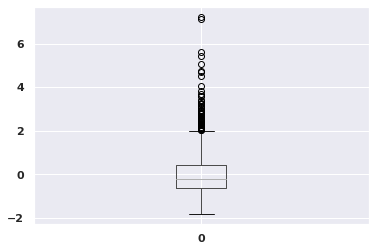

In [98]:
saleprice_scaled = StandardScaler().fit_transform(df['SalePrice'][:,np.newaxis]);
df_standized = pd.DataFrame(saleprice_scaled)
bp = df_standized.boxplot() 

# low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
# high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
# print('outer range (low) of the distribution:')
# print(low_range)
# print('\nouter range (high) of the distribution:')
# print(high_range)

We see in the boxplot that we have quite a few upper outliers. This tells us that house prices are prone to more expensive exceptions and we shouldn't be expecting any cheaper exceptions.

Regardless, we need to remove any outliers before creating our model. Take a loot at the scatter plot below:

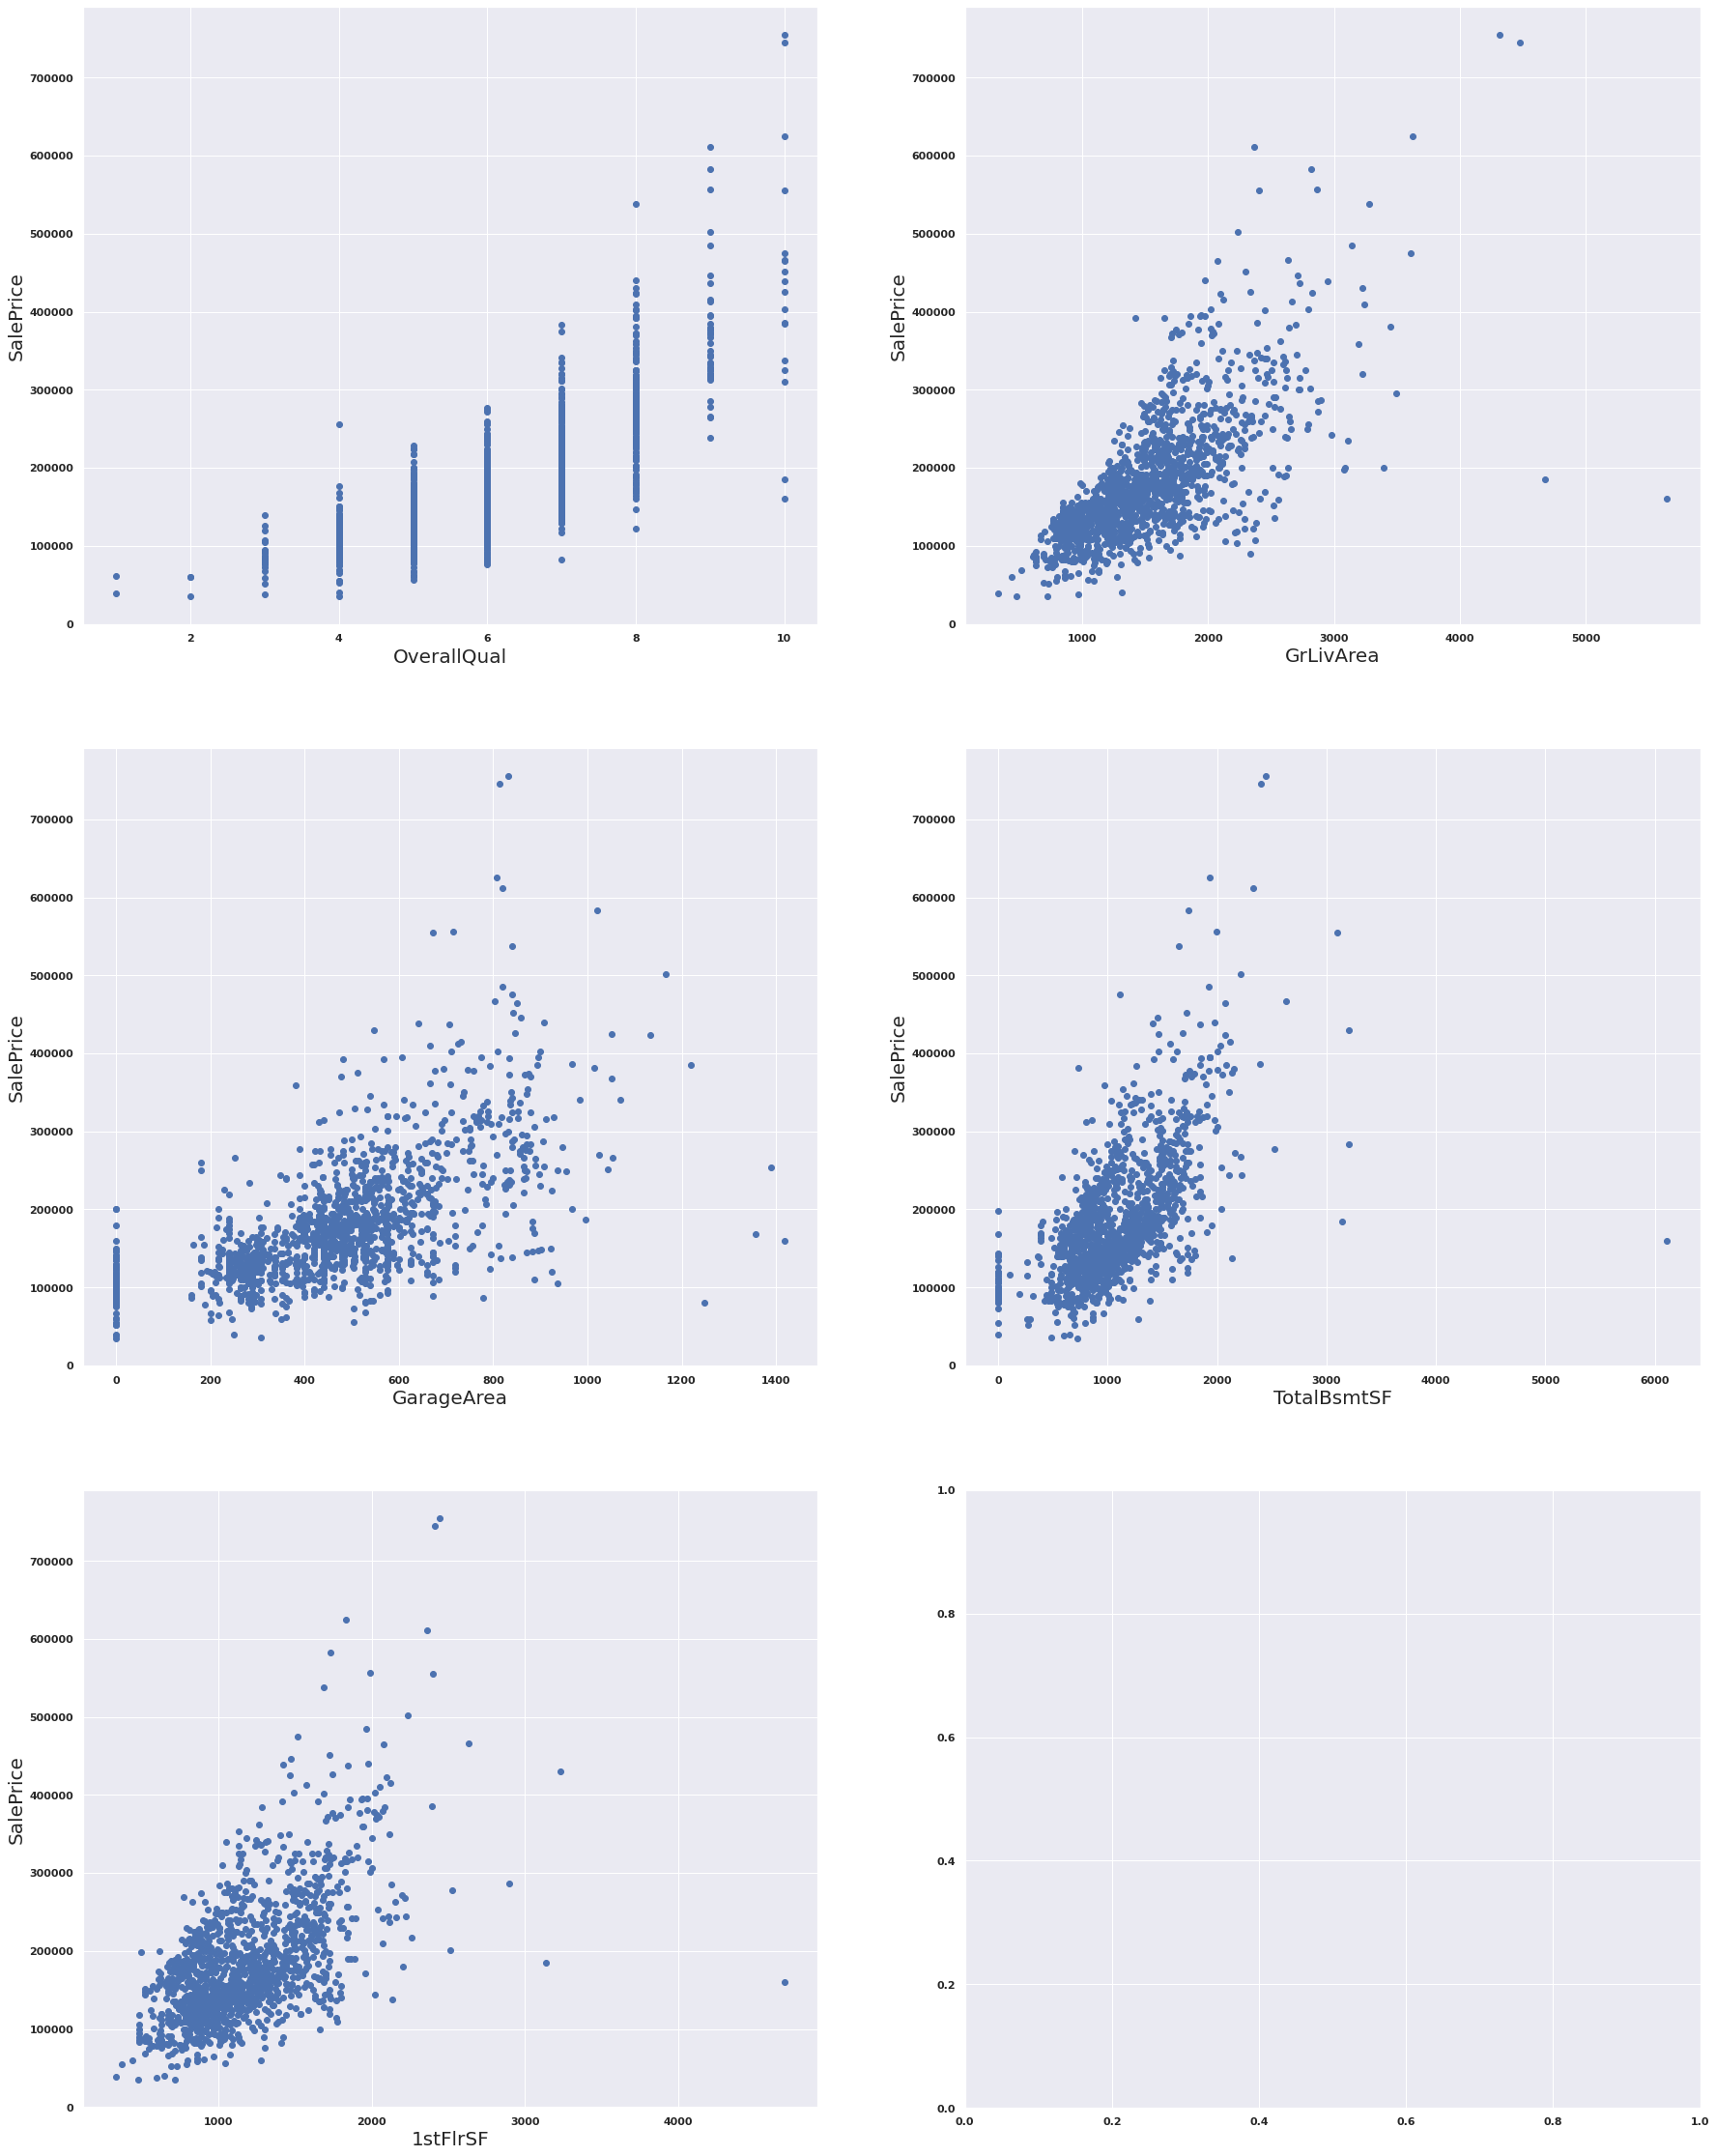

In [99]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize =(30,40))

ax1.set_xlabel('OverallQual', fontsize=20)
ax1.set_ylabel('SalePrice', fontsize=20)
ax2.set_xlabel('GrLivArea', fontsize=20)
ax2.set_ylabel('SalePrice', fontsize=20)
ax3.set_xlabel('GarageArea', fontsize=20)
ax3.set_ylabel('SalePrice', fontsize=20)
ax4.set_xlabel('TotalBsmtSF', fontsize=20)
ax4.set_ylabel('SalePrice', fontsize=20)
ax5.set_xlabel('1stFlrSF', fontsize=20)
ax5.set_ylabel('SalePrice', fontsize=20)


Y = df['SalePrice']
X1 = df['OverallQual']
X2 = df['GrLivArea']
X3 = df['GarageArea']
X4 = df['TotalBsmtSF']
X5 = df['1stFlrSF']


ax1.scatter(X1, Y)
ax2.scatter(X2, Y)
ax3.scatter(X3, Y)
ax4.scatter(X4, Y)
ax5.scatter(X5, Y)

There are potential outliers that catch our eyes. To systematically detect and remove outliers we can:
1. Compute the Z-score of each value in the column, relative to the column mean and standard deviation
2. Get absolute value of the Z-score and check if it's below the threshold
3. Check whether all rows each column satisfy this condition (below threshold)
4. Result of this condition is used to index the dataframe.

In most large data sets, 99% of values have a Z-score between -3 and 3, meaning they lie within three standard deviations above and below the mean. Therefore we can set the condition for the absolute Z-score to be lower than 3


In [100]:
df_std = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

Let's see the scatter plot again. This time we set the x and y axis limit to be the same as above for visual comparison.

(0.0, 700000.0)

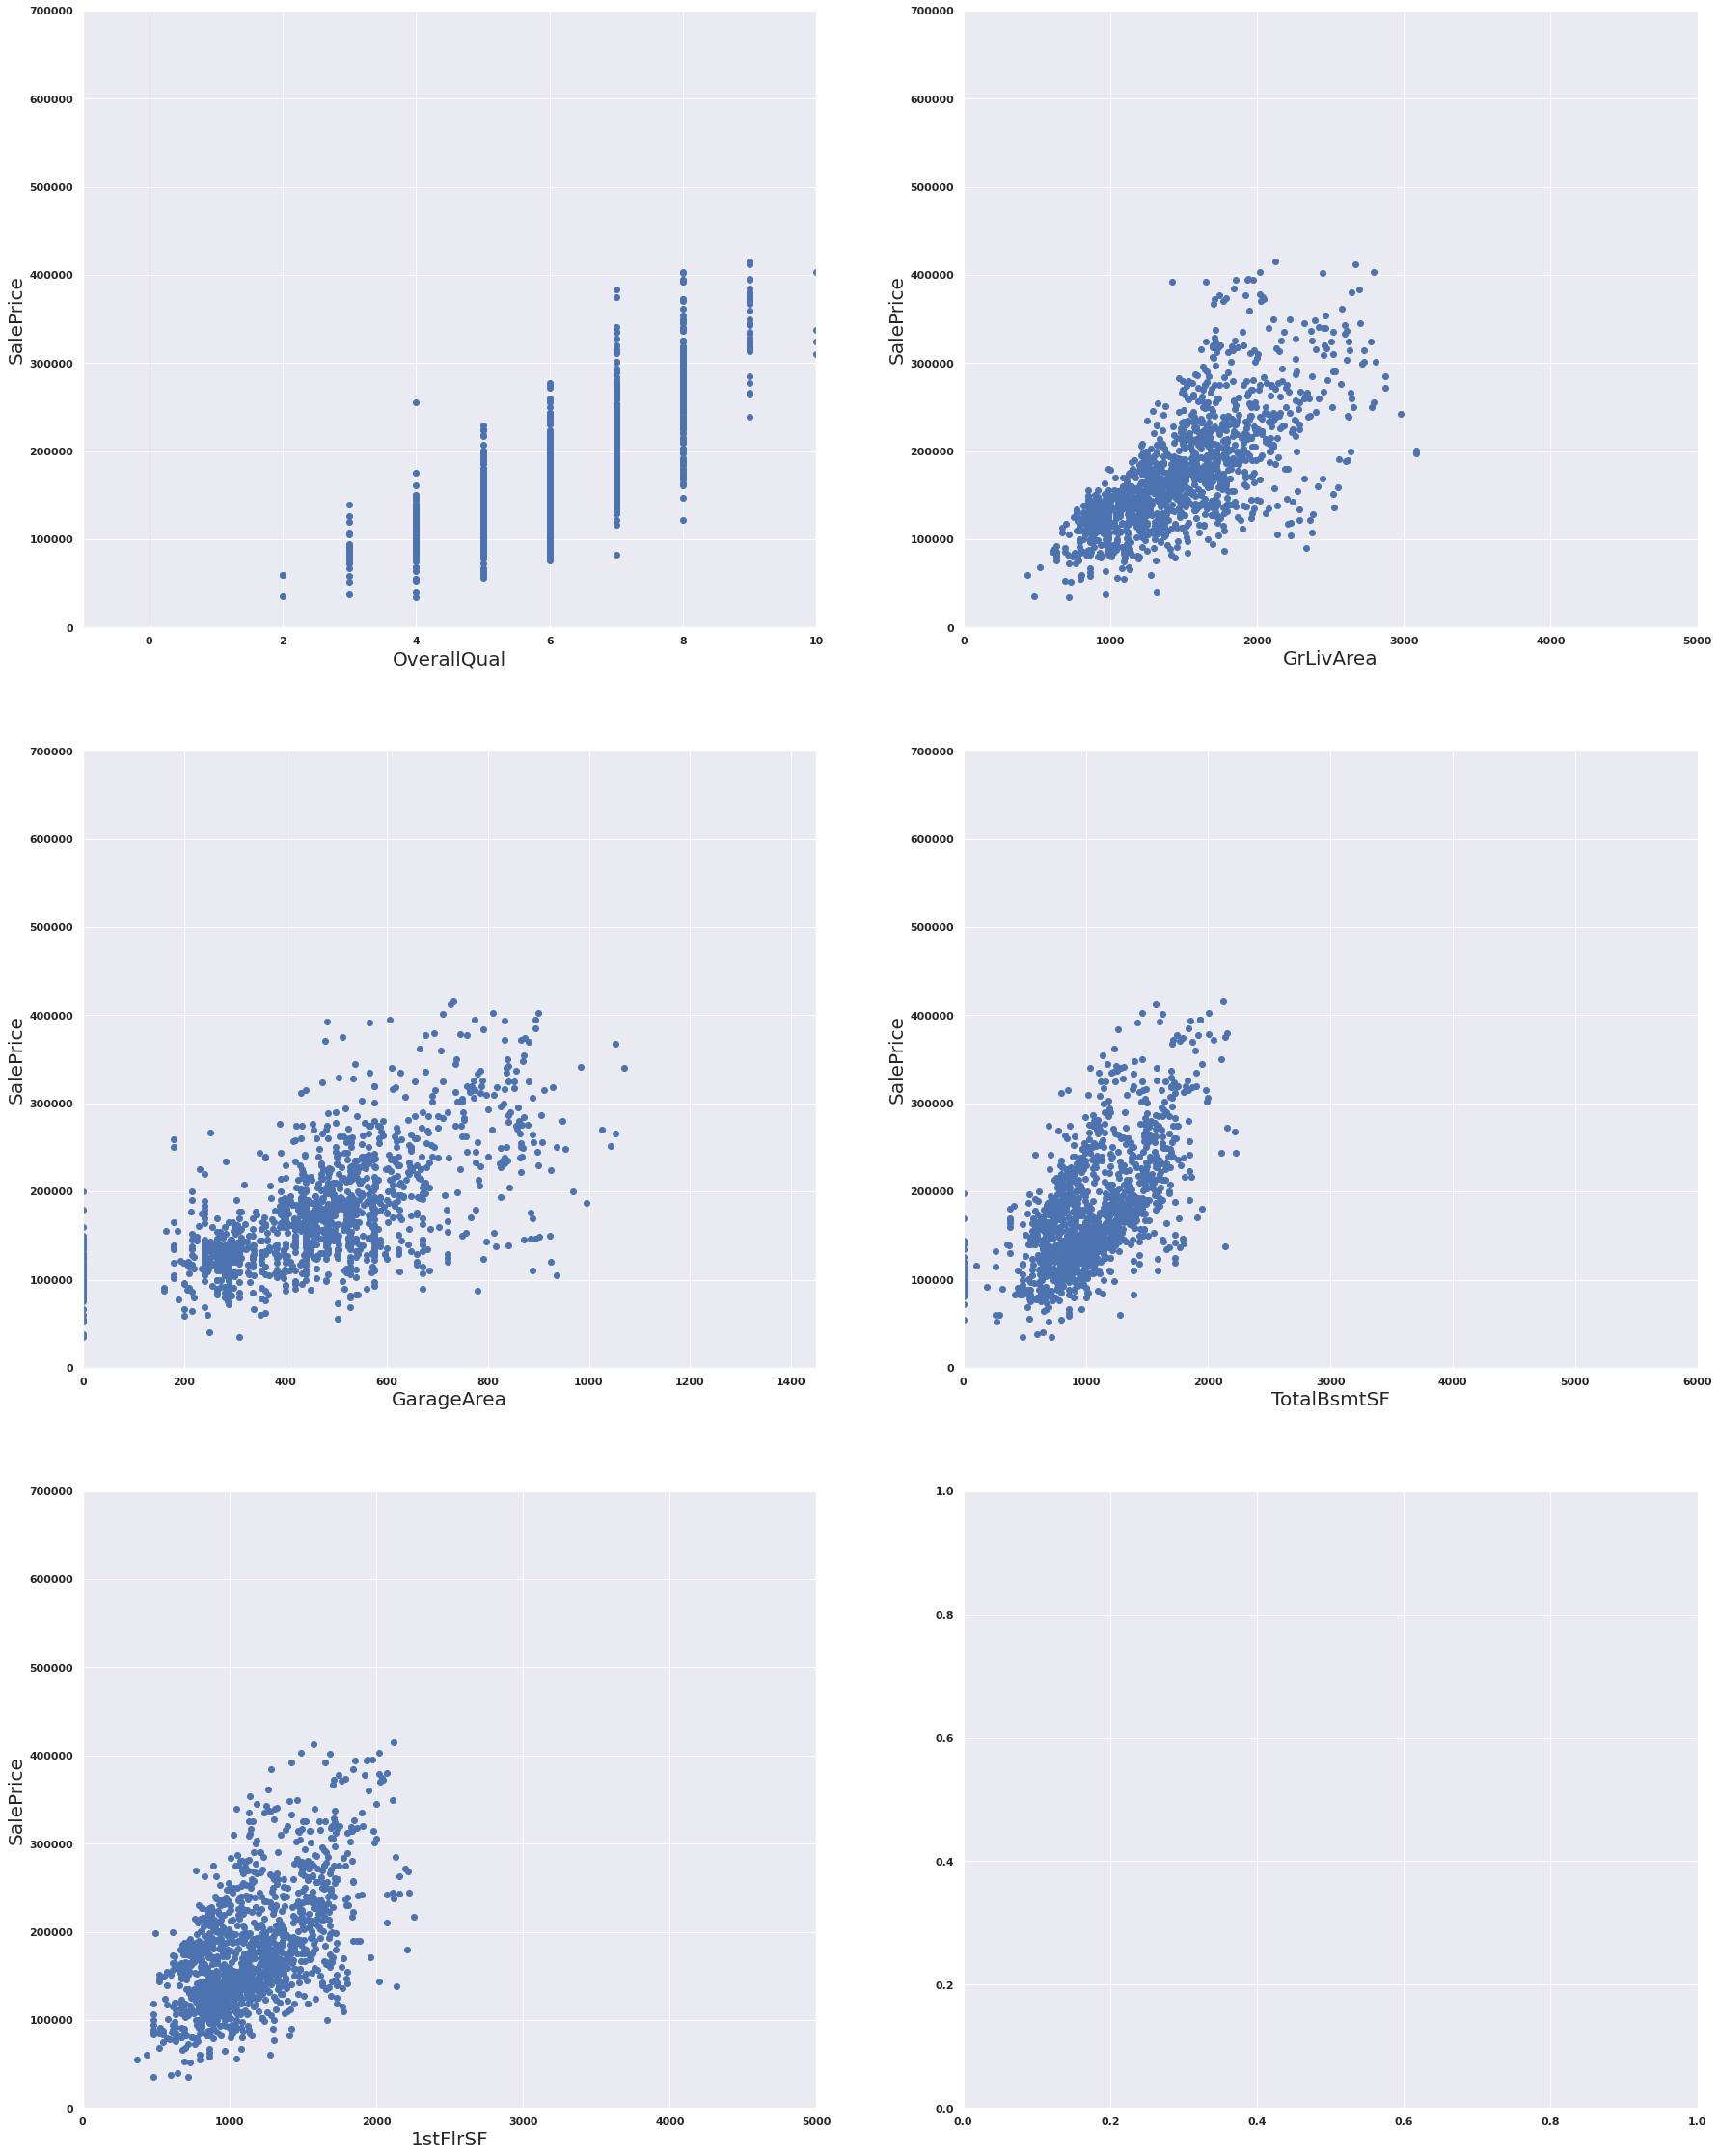

In [101]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize =(30,40))

ax1.set_xlabel('OverallQual', fontsize=20)
ax1.set_ylabel('SalePrice', fontsize=20)
ax2.set_xlabel('GrLivArea', fontsize=20)
ax2.set_ylabel('SalePrice', fontsize=20)
ax3.set_xlabel('GarageArea', fontsize=20)
ax3.set_ylabel('SalePrice', fontsize=20)
ax4.set_xlabel('TotalBsmtSF', fontsize=20)
ax4.set_ylabel('SalePrice', fontsize=20)
ax5.set_xlabel('1stFlrSF', fontsize=20)
ax5.set_ylabel('SalePrice', fontsize=20)


Y = df_std['SalePrice']
X1 = df_std['OverallQual']
X2 = df_std['GrLivArea']
X3 = df_std['GarageArea']
X4 = df_std['TotalBsmtSF']
X5 = df_std['1stFlrSF']

ax1.scatter(X1, Y)
ax2.scatter(X2, Y)
ax3.scatter(X3, Y)
ax4.scatter(X4, Y)
ax5.scatter(X5, Y)

ax1.set_xlim((-1, 10))
ax1.set_ylim((0, 700000))
ax2.set_xlim((-1, 5000))
ax2.set_ylim((0, 700000))
ax3.set_xlim((-1, 1450))
ax3.set_ylim((0, 700000))
ax4.set_xlim((-1, 6000))
ax4.set_ylim((0, 700000))
ax5.set_xlim((-1, 5000))
ax5.set_ylim((0, 700000))


## 5. Create model - going hardcore

Now that we have our filtered data set, it is time to create our regression model. Let's create a 